# 1. 초기화
import lots of modules and set up filters regarding raw data

In [186]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from matplotlib import font_manager, rc

# ## matplotlib에 대해서 한글 깨짐 방지 - OSX
# # rc('font', family='AppleGothic')
# # matplotlib.rcParams['axes.unicode_minus'] = False   

# ## matplotlib에 대해서 한글 깨짐 방지 - Windows
# matplotlib.rcParams['axes.unicode_minus'] = False

import platform
# Window 
if platform.system() == 'Windows': 
    matplotlib.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin': 
    # Mac 
    matplotlib.rc('font', family='AppleGothic')
else: 
    #linux 
    matplotlib.rc('font', family='NanumGothic') 

# 그래프에 마이너스 표시가 되도록 변경 
matplotlib.rcParams['axes.unicode_minus'] = False



In [187]:
column_filter = ['배송자휴대전화번호', 'T기프트배송자휴대전화번호', '주문번호', '주문일', '취소일', '결제일', '개통일', '배송일', '모델명', '가입유형', '약정프로그램', '요금제', '무약정Plan선택여부', 
                        '결제방법', '배송방법', '대리점', '주문유형', '쿠폰여부', '지인(추천인)코드', '개통일자', '센터명', '모바일구매여부', '상품구분(맞춤/패키지)', 
                        '서비스관리번호', 'TG상태값', '주문구분', '상담사소속', '대리점코드(중분류)', '외부유입경로', '약정구분', '포인트결제', '동의방법', 
                        '뉴보상기변 쓰던폰반납여부', '오늘보상 신청여부', '오늘보상 수거상태', '클럽기변 신청서 상태', 'T 갤럭시 클럽', '클럽기변 단말기할부금 면제금액', 
                        '대리점명', '매장명', 'D코드', '발송일']

# 개별 데이터를 상반부와 하반부를 합쳐서 생성

In [188]:
# 기준이 되는 24일 ars 인입 고객 정보 로딩 - 나이 연령 정보 포함됨
customer_24 = pd.DataFrame(pd.read_csv('./access_nums_age_sex.csv'),columns=['전화번호', '나이', '성별'])
customer_24['나이'] = pd.to_numeric (customer_24['나이'], errors = 'coerce')
customer_24_drop_na = customer_24.dropna (axis=0)
index_names = customer_24_drop_na[ customer_24_drop_na['성별'] == '#' ].index

customer_24_drop_na.drop(index_names, inplace=True)
#display(customer_24_drop_na)

C:\Users\Home\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## 8월 24일 상담센터 인입고객 성별 비율 계산 및 시각화

In [189]:
## 24일 인입된 데이터에 대해서 성별로 정리해서 개수를 세도록 한다.
pivot_sex = pd.pivot_table(customer_24_drop_na, index="성별", values=['전화번호'], aggfunc='count')
display(pivot_sex)


,전화번호
성별,
남,5105
여,3438


<AxesSubplot:ylabel='전화번호'>

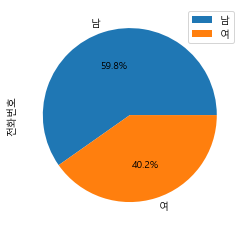

In [190]:
pivot_sex.plot.pie(y="전화번호", autopct='%1.1f%%')

### 위 차트 상으로 남자가 비중이 높다고 볼 수 있지만, 이 내용만으로 유의미한 결론이 나오지 않는다. 오히려, 성별과 나이대를 계산 hitmap을 그리도록 하자

In [191]:
## 히트맵 계산을 위해서, 나이대를 10 살 단위 기준으로 데이터를 정형화 하도록 한다.
## 이를 위해서 기존 데이터에 신규 칼럼 - "연령대" 을 추가하도록 하자.

age_band_width = 10
customer_24_drop_na['나이대'] = customer_24_drop_na['나이'].apply (lambda x: int(x/age_band_width) * age_band_width)
#customer_24_drop_na.head()

pivot_sex_age = pd.pivot_table(customer_24_drop_na, index="성별", columns = ["나이대"], values=['전화번호'], aggfunc='count')
display(pivot_sex_age)

C:\Users\Home\AppData\Local\Temp/ipykernel_27836/4061808374.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_24_drop_na['나이대'] = customer_24_drop_na['나이'].apply (lambda x: int(x/age_band_width) * age_band_width)


전화번호                                                             
나이대   0     10      20      30      40     50     60    70    80   90
성별                                                                   
남    5.0  42.0  1058.0  1668.0  1382.0  660.0  219.0  62.0   9.0  NaN
여    5.0  21.0   760.0  1243.0   857.0  330.0  153.0  51.0  17.0  1.0

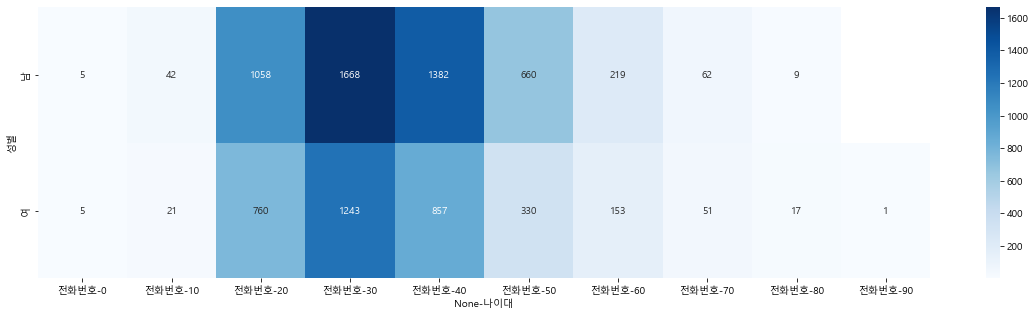

In [192]:
fig = plt.figure(figsize=(20,5))
fig.set_facecolor('white')
 
sns.heatmap(pivot_sex_age, cmap='Blues', annot=True, fmt=".0f")
plt.show()

## 28일 하루 기준으로 상담센터에 전화를 한 고객의 나이 및 성별에 대해서는 다음과 같이 정리 가능
* 상대적으로 여자 보다 남자가 좀 더 전화를 통해서 예판 참여 후 상담센터에 전화를 걸었다.
* 분포 자체는 남성/여성 모두에 있어서 30대가 가장 높은 비중으로 전화로 연결을 많이 했다.

위와 같은 상담센터 이용에 있어서 성별, 나이별 차이는 현재 대상 데이터가 예판 대상 장비와 연관이 있어서, 일반적이지는 않다라고 판단이 가능.

# 실제 위 분포의 특이성을 확인하기 위해선, **전체 갤럭시 폴더블 예판 참가자 분포와 차이가 있는지 분석이 필요**

# 예판 시점에 상담센터에 전화를 한 고객 특성을 분석하자. 우리는 상담센터에 전화를 건 사람들이 가지고 있는 특성이 궁금하다. 
* 예를 들어서 어떤 특정 요금제를 사용하는 사람들인지 아니면 어떤 개통 상 특이 사항이 있는 고객들인지?
* 특정 가입 채널 분포가 더 높은지 이것도 아니면, 가입 단말이 특이 하던지?
* 이러한 관점들에 대해서 실제 데이터를 기준으로 검증을 해나가고자 한다.

# 관련 데이터 준비 단계 - 원 주문 데이터와 접근자 핸폰 정보를 하나로 구성

## 고객별 주문 데이터를 준비 - orders

In [193]:
# 모바일 주문 정보 로딩 
mobile_order_1 = pd.DataFrame (pd.read_csv('./1_m.csv', dtype={'배송자휴대전화번호':str, 'T기프트배송자휴대전화번호':str}), columns=column_filter)
mobile_order_2 = pd.DataFrame (pd.read_csv('./2_m.csv', dtype={'배송자휴대전화번호':str, 'T기프트배송자휴대전화번호':str}), columns=column_filter)
mobile_orders = pd.concat([mobile_order_1, mobile_order_2], ignore_index=True, axis=0)
mobile_orders.reset_index(drop=True)

C:\Users\Home\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (108) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Home\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (11,53,54,55,56,117,118,119,120,121) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,배송자휴대전화번호,T기프트배송자휴대전화번호,주문번호,주문일,취소일,결제일,개통일,배송일,모델명,가입유형,...,뉴보상기변 쓰던폰반납여부,오늘보상 신청여부,오늘보상 수거상태,클럽기변 신청서 상태,T 갤럭시 클럽,클럽기변 단말기할부금 면제금액,대리점명,매장명,D코드,발송일
0,01033542025,NaN,210815569865/20210815235650624,2021-08-15 23:35:29,NaN,NaN,2021-08-19,NaN,SM-G988N_256GA,기기변경,...,N,미신청,NaN,미신청,NaN,NaN,NaN,NaN,NaN,NaN
1,01053387519,01053387519,210815569832,2021-08-15 23:19:53,2021-08-16 14:42:55,2021-08-15 23:19:53,NaN,NaN,IPHONE_12_PRO_128GB,기기변경,...,N,미신청,NaN,미신청,NaN,NaN,NaN,NaN,NaN,NaN
2,01091826959,01091826959,210815569822,2021-08-15 23:14:09,NaN,2021-08-15 23:14:09,2021-08-18,2021-08-18 10:14:00,IPHONE_12_128GB,기기변경,...,N,미신청,NaN,미신청,NaN,NaN,NaN,NaN,NaN,2021-08-17
3,01040536924,01040536924,210815569799,2021-08-15 23:05:21,2021-08-16 14:53:46,2021-08-15 23:05:21,NaN,NaN,IPHONE_12_MINI_256GGR,기기변경,...,N,미신청,NaN,미신청,NaN,NaN,NaN,NaN,NaN,NaN
4,01044551511,01044551511,210815569790,2021-08-15 23:03:29,2021-08-15 23:18:16,2021-08-15 23:03:29,NaN,NaN,SM-G998N_256GS,기기변경,...,N,미신청,NaN,미신청,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69714,01085198734,01085198734,210816569996,2021-08-16 00:38:16,2021-08-16 14:13:07,2021-08-16 00:38:16,NaN,NaN,IPHONE_12_128GW,기기변경,...,N,미신청,NaN,미신청,NaN,NaN,NaN,NaN,NaN,NaN
69715,01050659647,01050659647,210816569991,2021-08-16 00:30:55,NaN,2021-08-16 00:30:55,2021-08-19,2021-08-18 14:46:00,IPHONE_12_PRO_128GG,기기변경,...,N,미신청,NaN,미신청,NaN,NaN,NaN,NaN,NaN,2021-08-17
69716,01044514776,01051764776,210816569933,2021-08-16 00:06:57,NaN,2021-08-16 00:06:57,2021-08-19,2021-08-18 17:24:00,OMD XIAOMI REDMI NOTE 10 PRO,기기변경,...,N,미신청,NaN,미신청,NaN,NaN,NaN,NaN,NaN,2021-08-17
69717,01041103858,01041103858,210816569931,2021-08-16 00:05:39,2021-08-16 00:06:35,2021-08-16 00:05:39,NaN,NaN,SM-G998N_256G,기기변경,...,N,신청,신청,미신청,NaN,NaN,NaN,NaN,NaN,NaN


In [194]:
# 바로픽업 정보들 로딩
pickup_order_1 = pd.DataFrame (pd.read_csv('./1_b.csv', dtype={'배송자휴대전화번호':str, 'T기프트배송자휴대전화번호':str}), columns=column_filter)
pickup_order_2 = pd.DataFrame (pd.read_csv('./2_b.csv', dtype={'배송자휴대전화번호':str, 'T기프트배송자휴대전화번호':str}), columns=column_filter)
pickup_orders = pd.concat([pickup_order_1, pickup_order_2], ignore_index=True, axis=0)
pickup_orders.reset_index(drop=True)

,배송자휴대전화번호,T기프트배송자휴대전화번호,주문번호,주문일,취소일,결제일,개통일,배송일,모델명,가입유형,...,뉴보상기변 쓰던폰반납여부,오늘보상 신청여부,오늘보상 수거상태,클럽기변 신청서 상태,T 갤럭시 클럽,클럽기변 단말기할부금 면제금액,대리점명,매장명,D코드,발송일
0,NaN,01071245017,210815569889,2021-08-15 23:50:18,NaN,2021-08-15 23:50:18,NaN,NaN,SM-G991N,기기변경,...,N,NaN,NaN,미신청,NaN,NaN,PS&M,PS&M (수유점),NaN,NaN
1,NaN,01093663558,210815569871,2021-08-15 23:43:42,NaN,2021-08-15 23:43:42,NaN,NaN,IPHONE7_128GB,기기변경,...,N,NaN,NaN,미신청,NaN,NaN,이안,이안대리점 신림역점,NaN,NaN
2,NaN,01063651314,210815569845,2021-08-15 23:31:14,NaN,2021-08-15 23:31:14,NaN,NaN,IPHONE_11_PRO_256GM,기기변경,...,N,NaN,NaN,미신청,NaN,NaN,PS&M,PS&M (천안신불당점),NaN,NaN
3,NaN,01045948511,210815569834,2021-08-15 23:24:07,NaN,2021-08-15 23:24:07,NaN,NaN,IPHONE_11_PRO_256GM,기기변경,...,N,NaN,NaN,미신청,NaN,NaN,ACT대리점,ACT대리점 광운대점,NaN,NaN
4,NaN,01044422873,210815569793,2021-08-15 23:17:38,NaN,2021-08-15 23:17:38,NaN,NaN,IPHONE_11_PRO_256GM,기기변경,...,N,NaN,NaN,미신청,NaN,NaN,ACT대리점,ACT대리점 방학본점,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9630,NaN,01054055432,210816569990,2021-08-16 00:39:13,NaN,2021-08-16 00:39:13,NaN,NaN,IPHONE_11_PRO_256GB,기기변경,...,N,NaN,NaN,미신청,NaN,NaN,홍릉대리점,홍릉대리점 동대문점,NaN,NaN
9631,NaN,01092877745,210816570002,2021-08-16 00:36:56,NaN,2021-08-16 00:36:56,NaN,NaN,SM-G998N_256G,기기변경,...,N,NaN,NaN,미신청,NaN,NaN,PS&M,PS&M (영통점),NaN,NaN
9632,NaN,01035960413,210816569979,2021-08-16 00:28:52,NaN,2021-08-16 00:28:52,NaN,NaN,IPHONE_11_PRO_256GM,기기변경,...,N,NaN,NaN,미신청,NaN,NaN,아이티대리점,아이티대리점 수원탑동점,NaN,NaN
9633,NaN,01094509312,210816569954,2021-08-16 00:22:38,NaN,2021-08-16 00:22:38,NaN,NaN,SM-N981NB,기기변경,...,N,NaN,NaN,미신청,NaN,NaN,한솔대리점,한솔대리점 시청점,NaN,NaN


In [195]:
# build up a merged dataframe that includes all data (mobile and pickup)
# 하나로 값들을 통합하는 동시에, 전화번호 중 유효한 번호로 데이터를 조합 새로운 칼럼을 만들었다.


orders = pd.concat([mobile_orders, pickup_orders], ignore_index=True, axis=0)

def merge_phone_num (row) :
    if row['배송자휴대전화번호'] != 'NaN' and isinstance(row['배송자휴대전화번호'], str) == True:
        return str(row['배송자휴대전화번호'])
    else:
        # if np.isnan(row['배송자휴대전화번호']) :
        #     print (">>" + str(type(row['배송자휴대전화번호'])) + " -- "+str(row['배송자휴대전화번호'] + " ;;; "+str(row['T기프트배송자휴대전화번호'])))
        # print ("target: "+row['배송자휴대전화번호']+" ---> "+row['T기프트배송자휴대전화번호'])
        return str(row['T기프트배송자휴대전화번호'])


orders['PhoneNum'] = orders.apply(lambda row: merge_phone_num(row), axis=1)

orders


,배송자휴대전화번호,T기프트배송자휴대전화번호,주문번호,주문일,취소일,결제일,개통일,배송일,모델명,가입유형,...,오늘보상 신청여부,오늘보상 수거상태,클럽기변 신청서 상태,T 갤럭시 클럽,클럽기변 단말기할부금 면제금액,대리점명,매장명,D코드,발송일,PhoneNum
0,01033542025,NaN,210815569865/20210815235650624,2021-08-15 23:35:29,NaN,NaN,2021-08-19,NaN,SM-G988N_256GA,기기변경,...,미신청,NaN,미신청,NaN,NaN,NaN,NaN,NaN,NaN,01033542025
1,01053387519,01053387519,210815569832,2021-08-15 23:19:53,2021-08-16 14:42:55,2021-08-15 23:19:53,NaN,NaN,IPHONE_12_PRO_128GB,기기변경,...,미신청,NaN,미신청,NaN,NaN,NaN,NaN,NaN,NaN,01053387519
2,01091826959,01091826959,210815569822,2021-08-15 23:14:09,NaN,2021-08-15 23:14:09,2021-08-18,2021-08-18 10:14:00,IPHONE_12_128GB,기기변경,...,미신청,NaN,미신청,NaN,NaN,NaN,NaN,NaN,2021-08-17,01091826959
3,01040536924,01040536924,210815569799,2021-08-15 23:05:21,2021-08-16 14:53:46,2021-08-15 23:05:21,NaN,NaN,IPHONE_12_MINI_256GGR,기기변경,...,미신청,NaN,미신청,NaN,NaN,NaN,NaN,NaN,NaN,01040536924
4,01044551511,01044551511,210815569790,2021-08-15 23:03:29,2021-08-15 23:18:16,2021-08-15 23:03:29,NaN,NaN,SM-G998N_256GS,기기변경,...,미신청,NaN,미신청,NaN,NaN,NaN,NaN,NaN,NaN,01044551511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79349,NaN,01054055432,210816569990,2021-08-16 00:39:13,NaN,2021-08-16 00:39:13,NaN,NaN,IPHONE_11_PRO_256GB,기기변경,...,NaN,NaN,미신청,NaN,NaN,홍릉대리점,홍릉대리점 동대문점,NaN,NaN,01054055432
79350,NaN,01092877745,210816570002,2021-08-16 00:36:56,NaN,2021-08-16 00:36:56,NaN,NaN,SM-G998N_256G,기기변경,...,NaN,NaN,미신청,NaN,NaN,PS&M,PS&M (영통점),NaN,NaN,01092877745
79351,NaN,01035960413,210816569979,2021-08-16 00:28:52,NaN,2021-08-16 00:28:52,NaN,NaN,IPHONE_11_PRO_256GM,기기변경,...,NaN,NaN,미신청,NaN,NaN,아이티대리점,아이티대리점 수원탑동점,NaN,NaN,01035960413
79352,NaN,01094509312,210816569954,2021-08-16 00:22:38,NaN,2021-08-16 00:22:38,NaN,NaN,SM-N981NB,기기변경,...,NaN,NaN,미신청,NaN,NaN,한솔대리점,한솔대리점 시청점,NaN,NaN,01094509312


## 고객 센터 인입 고객 데이터 준비 - accesslog

In [196]:
# raw data를  읽어들임임
accesslog = pd.DataFrame (pd.read_csv('./access_raw.csv'))
index_names = accesslog[ accesslog['PhoneNum'] == '*' ].index

accesslog.drop(index_names, inplace=True)
display (accesslog)

,PhoneNum,인입일자,인입시간,상담사연결
0,01053174677,2021-08-24,00:09,X
1,01051441183,2021-08-24,00:11,X
2,01051441183,2021-08-24,00:12,X
3,01076541372,2021-08-24,00:17,X
4,01028039253,2021-08-24,00:21,X
...,...,...,...,...
109590,01091514026,2021-08-31,15:51,O
109591,01091726221,2021-08-31,16:41,O
109592,01050072852,2021-08-31,16:57,O
109593,01023215404,2021-08-31,17:16,X


In [197]:
# pivot으로 ID(전화번호) 별 전화 회수 테이블 구성
pivot_call_history = pd.pivot_table(accesslog, index="PhoneNum", values=['인입일자'], aggfunc='count')
pivot_call_history.columns.to_list()

reshaped_call_history = pivot_call_history.copy()
reshaped_call_history.columns = reshaped_call_history.columns.values
reshaped_call_history.reset_index (level=0, inplace=True)

reshaped_call_history


,PhoneNum,인입일자
0,00117342729800,1
1,00119174746208,5
2,00166819294158,2
3,001821062119600,2
4,00207043070670,8
...,...,...
27760,7088575339,3
27761,7088743701,1
27762,7088924665,3
27763,8613735007430,1


In [198]:
# 전화건 고객과 주문 내역을 묶어서 caller_and_order DataFrame을 구성하자.
caller_and_order = pd.merge(reshaped_call_history, orders, how="left", on="PhoneNum")
display(caller_and_order)


,PhoneNum,인입일자,배송자휴대전화번호,T기프트배송자휴대전화번호,주문번호,주문일,취소일,결제일,개통일,배송일,...,뉴보상기변 쓰던폰반납여부,오늘보상 신청여부,오늘보상 수거상태,클럽기변 신청서 상태,T 갤럭시 클럽,클럽기변 단말기할부금 면제금액,대리점명,매장명,D코드,발송일
0,00117342729800,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00119174746208,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00166819294158,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,001821062119600,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00207043070670,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33208,7088575339,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33209,7088743701,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33210,7088924665,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33211,8613735007430,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [199]:
# 병합한 데이터 청소를 해야 한다. 주문번호가 없는 친구들 비중이 어떻게 되지?

cleaned_caller_and_order = caller_and_order[caller_and_order['주문번호'].notna()]
cleaned_caller_and_order.reindex()


,PhoneNum,인입일자,배송자휴대전화번호,T기프트배송자휴대전화번호,주문번호,주문일,취소일,결제일,개통일,배송일,...,뉴보상기변 쓰던폰반납여부,오늘보상 신청여부,오늘보상 수거상태,클럽기변 신청서 상태,T 갤럭시 클럽,클럽기변 단말기할부금 면제금액,대리점명,매장명,D코드,발송일
15,01020000571,27,01020000571,01020000571,210818615393,2021-08-18 09:52:09,NaN,2021-08-18 09:52:09,2021-08-26,2021-08-25 09:50:00,...,N,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,2021-08-24
16,01020000571,27,01020000571,01020000571,210817598909,2021-08-17 15:48:40,2021-08-17 16:28:46,2021-08-17 15:48:40,NaN,NaN,...,N,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
17,01020000571,27,NaN,01020000571,210817601762,2021-08-17 16:50:46,NaN,2021-08-17 16:50:46,NaN,NaN,...,N,NaN,NaN,NaN,NaN,NaN,메트로대리점,메트로대리점 본점,NaN,NaN
18,01020000571,27,NaN,01020000571,210817601277,2021-08-17 16:40:54,NaN,2021-08-17 16:40:54,NaN,NaN,...,N,NaN,NaN,NaN,NaN,NaN,챌린저,챌린저대리점 본점,NaN,NaN
20,01020003772,2,01020003772,01020003772,210827739230,2021-08-27 18:19:38,NaN,2021-08-27 18:19:38,2021-08-31,2021-08-31 15:25:00,...,N,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,2021-08-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32874,01099998752,4,01099998752,01099998752,210831766078,2021-08-31 11:37:11,2021-08-31 13:11:36,2021-08-31 11:37:11,NaN,NaN,...,N,미신청,NaN,미신청,NaN,NaN,NaN,NaN,NaN,NaN
32875,01099999309,1,01099999309,01099999309,210817582473,2021-08-17 10:22:27,NaN,2021-08-17 10:22:27,2021-09-04,2021-09-04 16:17:00,...,N,미신청,NaN,미신청,NaN,NaN,NaN,NaN,NaN,2021-09-03
32877,01099999592,2,01099999592,01099999592,210817585466,2021-08-17 11:06:34,NaN,2021-08-17 11:06:34,2021-08-24,NaN,...,N,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
32878,01099999592,2,01099999592,01099999592,210817576103,2021-08-17 09:29:49,2021-08-17 11:08:32,2021-08-17 09:29:49,NaN,NaN,...,N,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [200]:
print ("전체 인입된 전화 번호 개수: "+ str(caller_and_order.size))
print ("실제 주문 번호와 매칭된 전화 개수:"+str(cleaned_caller_and_order.size))
ratio_of_no_order_id = cleaned_caller_and_order.size / caller_and_order.size
print (">> 주문 번호가 없는 전화 비중: "+ str((1 - ratio_of_no_order_id)*100))

전체 인입된 전화 번호 개수: 1461372
실제 주문 번호와 매칭된 전화 개수:994180
>> 주문 번호가 없는 전화 비중: 31.96940956854244


In [201]:
주문번호별_전화번호_개수 = pd.pivot_table (cleaned_caller_and_order, index="PhoneNum", values=['주문번호'], aggfunc='count', margins=True)
#display(주문번호별_전화번호_개수)

pivot_order_count_per_phoneNum = 주문번호별_전화번호_개수.copy()
pivot_order_count_per_phoneNum.columns = 주문번호별_전화번호_개수.columns.values
pivot_order_count_per_phoneNum.reset_index (level=0, inplace=True)
display(pivot_order_count_per_phoneNum)


pivot_hist_df = pd.pivot_table (pivot_order_count_per_phoneNum, index="주문번호", values=['PhoneNum'], aggfunc='count', margins=True)
display(pivot_hist_df)


,PhoneNum,주문번호
0,01020000571,4
1,01020003772,4
2,01020007318,1
3,01020008180,2
4,01020008320,1
...,...,...
17143,01099998752,2
17144,01099999309,1
17145,01099999592,2
17146,0221483843,1


,PhoneNum
주문번호,
1,13234
2,2963
3,666
4,174
5,57
6,20
7,10
8,6
9,7


In [202]:
#cleaned_caller_and_order.to_csv("../cleaned.csv", encoding = 'utf-8' )

## 전체 인입된 ARS 번호에 대해서 주문번호와 직접 매칭되지 않은 주문 번호들 값이 전체 인입 전화 중 약 32%를 차지한다.

### !!!! 아직 남은 의문.. 약 32%에 해당하는 주문과 연결되지 않은 전화 번호들은 어떤 것들일까??? 이 부분에 대해서 확인이 필요하다.

In [203]:
## 분석 전 기존 데이터에 대한 추가 가공

# 예판 모델을 구매한 주문인지 여부를 신규 칼럽으로 추가
def add_yn_column_for_folderble(row):
    modelcode = str(row['모델명'])
    if modelcode.startswith('SM-F711') or modelcode.startswith('SM-F926'):
        return "Y"
    else:
        return "N"

cleaned_caller_and_order['예판모델'] = cleaned_caller_and_order.apply(lambda row: add_yn_column_for_folderble(row), axis=1)

C:\Users\Home\AppData\Local\Temp/ipykernel_27836/2975262207.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_caller_and_order['예판모델'] = cleaned_caller_and_order.apply(lambda row: add_yn_column_for_folderble(row), axis=1)


# 분석  수행을 하도록 한다.
---- 
## 분석 1. 24일 기준 인입된 고객들 성별/연령 특이 사항이 있는가?
----

### 본 항목에 대해서는 앞선 데이터 분석 결과 참고
### 현재 성별이나 연령에 있어서 특이 사항이 보이지는 않는다.

----
## 분석 2. 예판 기간 고객센터 전화 건 고객들 가입유형 특성은 어떻게 되는가?
----


In [204]:
join_pattern_pivot = pd.pivot_table (cleaned_caller_and_order, index=["가입유형"], values=['PhoneNum'], aggfunc=(lambda x: len(x.unique())), margins=True)
display(join_pattern_pivot)

join_pattern_pivot_1 = pd.pivot_table (cleaned_caller_and_order, index=["가입유형","예판모델"], values=['PhoneNum'], aggfunc=(lambda x: len(x.unique())), margins=True)
display(join_pattern_pivot_1)


,PhoneNum
가입유형,
기기변경,14572
번호이동,434
신규가입,2856
All,17147


PhoneNum
가입유형 예판모델          
기기변경 N         3413
     Y        11362
번호이동 N          116
     Y          321
신규가입 N         2807
     Y           51
All           17147

## 위 데이터를 보게 되면, 절대다수가 기기변경을 진행하는 고객이며, 이 중에서도 예판 참석을 했던 고객들인 것은 자명해 보인다.
## 그런데, 고객 회수 기준으로 반복 전화를 건 고객 특성 확인하기 위해서, 이들에 대한 전화 회수 데이터도 추가한다.

In [226]:
join_pattern_pivot_2 = pd.pivot_table (cleaned_caller_and_order, index=["가입유형"], values=['인입일자'], aggfunc='sum')
join_pattern_pivot_2_1 = pd.pivot_table (cleaned_caller_and_order, index=["가입유형"], values=['PhoneNum'], aggfunc=(lambda x: len(x.unique())))

#display(join_pattern_pivot_2)

join_pattern_merge = pd.merge(join_pattern_pivot_2_1, join_pattern_pivot_2, how="left", on="가입유형")
join_pattern_ratio = join_pattern_merge.copy()
join_pattern_ratio.columns = join_pattern_merge.columns.values
join_pattern_ratio.reset_index (level=0, inplace=True)

def cal_ratio(row):
    return row['인입일자'] / row['PhoneNum']

join_pattern_ratio["1인당 콜 회수 평균"] = join_pattern_ratio.apply(lambda row: cal_ratio(row), axis=1)
display(join_pattern_ratio)

,가입유형,PhoneNum,인입일자,1인당 콜 회수 평균
0,기기변경,14572,88614,6.081114
1,번호이동,434,2733,6.297235
2,신규가입,2856,17817,6.238445


## 상대적으로 1인당 콜 회수 평균은 번호이동 이나 신규가입 같이 기존 SKT가 아닌 타사 고객인 경우가 많은 것으로 보인다.
### 그런데, 평균 1인당 콜 회수가 6번이 넘어간다니.. 이 자체가 비정상적 아닌가? 물론 연결율이 안 좋았기는 해서 그렇다고 보인다만.
### 그렇다면 연결된 회수 기준으로 고객 연결 회수 분포를 및 평균을 확인해보면 어떨까?

C:\Users\Home\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


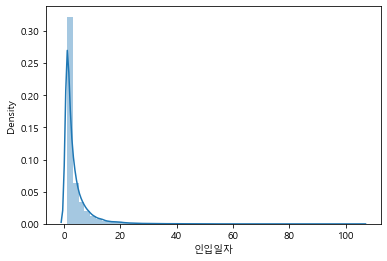

In [235]:
sns.distplot(reshaped_call_history['인입일자'])
plt.show()

In [236]:
accesslog_connected = accesslog[accesslog['상담사연결'] == 'O']
display(accesslog_connected)



,PhoneNum,인입일자,인입시간,상담사연결
203,01084111111,2021-08-24,08:59,O
217,01035844417,2021-08-24,08:59,O
218,01035780939,2021-08-24,08:59,O
219,01095659965,2021-08-24,08:59,O
223,01020084011,2021-08-24,09:00,O
...,...,...,...,...
109588,01031117202,2021-08-31,15:13,O
109589,01037351506,2021-08-31,15:34,O
109590,01091514026,2021-08-31,15:51,O
109591,01091726221,2021-08-31,16:41,O


----
## 분석 3. 예판 기간 고객센터 전화 건 고객들 가입채널은 어떻게 되는가?
----

In [ ]:
# 가입 채널별로 인입되었던 고객들 위치를 확인한다.
print ("전체 주문 수 : " + str(cleaned_caller_and_order['주문번호'].unique().size))

channel_order_sum = pd.pivot_table (cleaned_caller_and_order, index="주문구분", values=['주문번호'], aggfunc='count', margins=True)
#display(channel_order_sum)

channel_customer_sum = pd.pivot_table (cleaned_caller_and_order, index="주문구분", values=['PhoneNum'], aggfunc=(lambda x: len(x.unique())), margins=True)
#display(channel_customer_sum)


channel_status = pd.merge(channel_customer_sum, channel_order_sum, how='left', on='주문구분')
channel_status['고객당_주문_개수_비'] = channel_status.apply(lambda row: row['주문번호']/row['PhoneNum'], axis=1)
display(channel_status)




----
## 분석 4. 예판 기간 고객센터 전화 건 고객들 주된 가입 단말은 어떻게 되는가? 
----

In [ ]:
#print(cleaned_caller_and_order.columns.to_list)

In [177]:
# phone_model_df = cleaned_caller_and_order.copy()

def add_yn_column_for_folderble(row):
    modelcode = str(row['모델명'])
    if modelcode.startswith('SM-F711') or modelcode.startswith('SM-F926'):
        return "Y"
    else:
        return "N"

cleaned_caller_and_order['예판모델'] = cleaned_caller_and_order.apply(lambda row: add_yn_column_for_folderble(row), axis=1)

phone_model_pivot_level_1 = pd.pivot_table (cleaned_caller_and_order, index=["예판모델"], values=['주문번호'], aggfunc='count', margins=True)
display(phone_model_pivot_level_1)

phone_model_pivot_level_3 = pd.pivot_table (cleaned_caller_and_order, index=["예판모델"], values=['PhoneNum'], aggfunc=(lambda x: len(x.unique())), margins=True)

display(phone_model_pivot_level_3)

phone_model_pivot_level_2 = pd.pivot_table (cleaned_caller_and_order, index=["예판모델",'모델명'], values=['주문번호'], aggfunc='count', margins=True)
display(phone_model_pivot_level_2)

print("전체 콜센터 전화건 고객 중 예판 모델 외 건으로 전화한 고객 수 (6165명/17147명): "+ str(6165/17247*100) +"%")


C:\Users\Home\AppData\Local\Temp/ipykernel_27836/1146154694.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_caller_and_order['예판모델'] = cleaned_caller_and_order.apply(lambda row: add_yn_column_for_folderble(row), axis=1)


,주문번호
예판모델,
N,8029
Y,14566
All,22595


,PhoneNum
예판모델,
N,6165
Y,11699
All,17147


주문번호
예판모델 모델명                         
N    AT-M110S                  36
     AW6 40 BLU AL NAVY SP     16
     AW6 40 RED AL RED SP       1
     AW6 40 SIL SS WT SP        3
     AW6 44 SIL SS WT SP        1
...                           ...
Y    SM-F926N512GS            663
     SM-F926NG                442
     SM-F926NS                398
     SM-F926N_PXG             611
All                         22595

[267 rows x 1 columns]

전체 콜센터 전화건 고객 중 예판 모델 외 건으로 전화한 고객 수 (6165명/17147명): 35.7453470168725%


## 위 데이터에 따르면, 예판 모델에 의한 전화 통화 수가 전체 전화 발송 고객 주문번호 기준 36% 고객이 예판 때문에 전화를 한 것이 아니었다.
### !!! 예판 고객과 아닌 고객들의 전화 통화 인입 건수 비중 확인 필요

----
## 분석 5. 예판 기간 고객센터 전화 건 고객들 중 클럽기변 비중은?
----

In [181]:
club_package_pivot = pd.pivot_table (cleaned_caller_and_order, index=["클럽기변 신청서 상태", '예판모델'], values=['PhoneNum'], aggfunc=(lambda x: len(x.unique())), margins=True)
display(club_package_pivot)

print ("클럽기변 고객 수 비중: "+str(717/14572))

PhoneNum
클럽기변 신청서 상태 예판모델          
미신청         N         3413
            Y        10712
신청          Y          717
취소          Y          187
All                  14572

클럽기변 고객 수 비중: 0.049203952786165246


## 위 데이터에 따르면, 콜센터 전화 고객 중 클럽기변 신청자 비중은 약 5% 차지하며, 이 고객에 대한 대응이 전체 연결율을 향상 시키지는 않을 것 같다.
### !!! 반복 전화 고객 중에서 클럽 기변 비중에 대해서 확인이 필요하다.

----
## 분석 6. 예판 기간 고객센터 전화 건 고객들 라이트할부 신청여부 비중은?
----

In [ ]:
club_package_pivot = pd.pivot_table (cleaned_caller_and_order, index=["클럽기변 신청서 상태", '예판모델'], values=['PhoneNum'], aggfunc=(lambda x: len(x.unique())), margins=True)
display(club_package_pivot)

print ("클럽기변 고객 수 비중: "+str(717/14572))